<a href="https://colab.research.google.com/github/skbetz54/Samuel_DATA606/blob/main/Notebooks/Articles_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Article Testing**

The final Part of this project is to take what I've made in the [previous notebook](https://github.com/skbetz54/Samuel_DATA606/blob/main/Notebooks/Machine_Learning_Implementation.ipynb), it is finally time to test my RNN on real-world news articles from CNN and Fox News. The notebook contains several steps:

1. Data loading and cleaning - the data is loaded into the notebook and cleaned into a format that is applicable for testing in the RNN. This includes the standard text cleaning as well as creating a tensor representation of the string.
2. Model Loading - loading the model and the weights/biases of each layer into this notebooks to use.
3. Predictions - Creating several functions to help with making prediction using the model, as well as gaining insights from the prediction's output.
4. Results - Showing the results for the articles other other insights

In [1]:
!pip install textblob # used for quantifying polarity of the tweets in the dataset.


import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torchtext
import pickle


!git clone https://github.com/EdwardRaff/Inside-Deep-Learning.git
%run /content/Inside-Deep-Learning/idlmam.py

#Preprocessing Functions
from sklearn.utils import shuffle


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from wordcloud import WordCloud # EDA Tool
from textblob import TextBlob

from google.colab import files, drive

Cloning into 'Inside-Deep-Learning'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 10), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
open_path_cnn = "/content/gdrive/MyDrive/DATA606/Data/df_cnn_0518.csv"
open_path_fn = "/content/gdrive/MyDrive/DATA606/Data/df_foxnews_0518.csv"
open_path_15 = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned_15k.csv"



df_cnn = pd.read_csv(open_path_cnn)
df_fn = pd.read_csv(open_path_fn)

df_cnn['Site'] = 'Cnn'
df_fn['Site'] = 'Fox'
df_15 = pd.read_csv(open_path_15)


df_cnn =df_cnn.drop(columns='Unnamed: 0')
df_fn =df_fn.drop(columns='Unnamed: 0')
df_15 = df_15[['index','text','emotions','class','pos_or_neg','lemma_string','sentiment','word_length']]

In [5]:
df_cnn=df_cnn[['Title','lemma_string','Site']]
df_fn=df_fn[['Title','lemma_string','Site']]

df = pd.concat([df_cnn, df_fn], axis=0)
df.reset_index(drop=True, inplace=True)

In [6]:
# Cleaning out the extra spaces and punctuation

df['cleaned'] = df['lemma_string'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(' +', ' ',x))

In [10]:
# Create a vector from the entire cleaned string

df['vector'] = df.cleaned.apply(lambda x: list(x.split(sep =" ")))
df['vector_length'] = df.vector.apply(lambda x: len(x))


In [7]:
# Vocabulary Creation - News Sites

t1 = time.perf_counter()

combined = df.cleaned.str.cat()

idx2word = {0:'PAD',1:'SOS',2:'EOS'}

for word in combined.split():
  if word not in idx2word.values():
    idx2word[len(idx2word)] = word

t2 = time.perf_counter()

print("\nTime to create vocabulary: %f seconds" %(t2-t1))
print("Length of Vocabulary: %d" %(len(idx2word)))

word2idx = {v:k for k,v in idx2word.items()}


Time to create vocabulary: 9.032337 seconds
Length of Vocabulary: 15062


In [8]:
# Vocabulary - 15K Dataset
4
combined_15 = df_15.lemma_string.str.cat(sep = " ")

t1 = time.perf_counter()

idx2word_15 = {0:'PAD',1:'SOS',2:'EOS'}

for word in combined_15.split():
  if word not in idx2word_15.values():
    idx2word_15[len(idx2word_15)] = word

t2 = time.perf_counter()

print("\nTime to create vocabulary: %f seconds" %(t2-t1))
print("Length of Vocabulary: %d" %(len(idx2word_15)))


# Creating the inverse of the above dictionaries for the purpose of output formatting


word2idx_15 = {v: k for k, v in idx2word_15.items()}


Time to create vocabulary: 57.235896 seconds
Length of Vocabulary: 30000


In [11]:
# MOST IMPORTANT PART - We need to create a brand new vocabulary, where the index for each vocabulary lines up

"""
We need to create a brand new vocabulary, with the same length as the 
input vocab (30,000) where only words in our new dataset exist

"""

newvocab = {i:0 for i in range(len(idx2word))}

for key, value in word2idx_15.items():
  for k1, v1 in word2idx.items():
    if k1 == key:
      newvocab[value] = k1

newvocab[len(newvocab)] = df['vector'][0][-1]
newvocab[len(newvocab)] = df['vector'][0][1]

In [12]:
# Getting the average length of articles in dataste

dfa = df.loc[df.Site == "Cnn"]

dfb = df.loc[df.Site == "Fox"]

aa = len(dfa.vector_length)
ab =sum(dfa.vector_length)
avga = ab/aa

bb = len(dfb.vector_length)
bc =sum(dfb.vector_length)
avgb = bc/bb

b = len(df.vector_length)
a = sum(df.vector_length)
avg = a/b

print("FULL " + str(avg))
print("CNN " + str(avga))
print("Fox " + str(avgb))

FULL 828.7834394904459
CNN 876.6
Fox 598.5555555555555


In [13]:
# Create new 'Tensor" column to be inputted into the model

df['tensor'] = None

# Finally, creating a mapper using the above vocabulary to assign values to each nonblank sentence.
for position, vector in enumerate(df['vector']):

  sentence_vector  = torch.zeros(int(df['vector_length'][position]), dtype=torch.long)


  # Running through each individual vector - excluding first and last words because they contain blank spaces unable to be processed
  for index, word in enumerate(vector[1:-1]): 
    #Assigning an index value for each word within the values
    sentence_vector[index] = newvocab[word]
  df['tensor'][position] = sentence_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [14]:
df.head()

,Title,lemma_string,Site,cleaned,vector,vector_length,tensor
0,Opinion: It won't be long before extremists in...,julian zelizer cnn political analyst professor...,Cnn,julian zelizer cnn political analyst professor...,"[julian, zelizer, cnn, political, analyst, pro...",760,"[tensor(4), tensor(5), tensor(6), tensor(7), t..."
1,Michael Osterholm: Covid-19 keeps firing 210-m...,peter bergen cnn 's national security analyst ...,Cnn,peter bergen cnn s national security analyst v...,"[peter, bergen, cnn, s, national, security, an...",1317,"[tensor(517), tensor(5), tensor(97), tensor(51..."
2,Opinion: Katie Porter's example reveals a pivo...,( cnn ) private meeting house democratic caucu...,Cnn,cnn private meeting house democratic caucus l...,"[, cnn, private, meeting, house, democratic, c...",449,"[tensor(5), tensor(967), tensor(968), tensor(2..."
3,Opinion: Why the baby formula shortage is so t...,syra madad dhsc msc mcp infectious disease epi...,Cnn,syra madad dhsc msc mcp infectious disease epi...,"[syra, madad, dhsc, msc, mcp, infectious, dise...",578,"[tensor(1124), tensor(1125), tensor(1126), ten..."
4,Opinion: Trust in the Supreme Court is grievou...,barbara a. perry gerald l. baliles professor d...,Cnn,barbara a perry gerald l baliles professor dir...,"[barbara, a, perry, gerald, l, baliles, profes...",788,"[tensor(1314), tensor(1315), tensor(1316), ten..."


## **Model Loading**

In [28]:
# Instantiating the rnn that will be used with the state dict in the next cell to make predictions

D = 64 
vocab_size = len(newvocab)
hidden_nodes = 256 
classes = 6

lossfunc = nn.CrossEntropyLoss()

model_best = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

device = torch.device("cpu")

In [29]:
# Loading the best model created in the previous notebook it's state dictionary from after training.

statedictpath = r"/content/gdrive/My Drive/DATA606/BasicModels/BestModel/model_best.pt"

loader = torch.load(statedictpath)

loader2 = loader['model_state_dict']

model_best.load_state_dict(loader2)

<All keys matched successfully>

In [30]:
model_best.state_dict

<bound method Module.state_dict of Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(30000, 64)
  )
  (1): RNN(64, 256, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=256, out_features=6, bias=True)
)>

## **Testing and Predicting**

Now that our trained model is loaded, all we have to do is predict on each sample.


In [19]:
# Emotion Dataset

"""
-----------------------
Now that we have a completely new dictionary, we can bring in our emotion dataset, 
which is only really be used to get the predictions and associated labels of the incoming tensors since
we have already trained our data using this dataset 
-----------------------
"""


class EmotionDataset(Dataset):
  
  def __init__(self, dictionary, vocabulary):
    self.label_names = [name for name in dictionary.keys()]
    self.data = []
    self.labels = []
    self.vocabulary = vocabulary
    self.dictionary = dictionary
    self.max = 0

    """
    Iterate through the dataset's dictionary and extract both the tweet and its corresponding label.
    """

    for idx, emotion in enumerate(self.label_names):
      for sentence in dictionary[emotion]:
        self.data.append(sentence)
        self.labels.append(idx)

  def __len__(self):
    return len(self.data)
    """
    return the length of the datset.
    """


  def list2InputVec(self, input_list):
    """
    This method is going to take an input list (a.k.a the individual words within the sentence)
    and return a pytorch vector of long integers, where each integer represents the index within the assigned
    vocabulary. 
    """

    T = len(str(input_list).split(sep = " "))

    sentence_vect = torch.zeros((T), dtype=torch.long) 

    for position, vector in enumerate(str(input_list).split(sep=" ")):
      sentence_vect[position] = word2idx[vector]

    return sentence_vect

  def __getitem__(self, index):
    name = self.data[index]
    label = self.labels[index]
    
    label_vector = torch.tensor([label], dtype = torch.long)                                

    return self.list2InputVec(name), label

In [20]:
# 15K Downsampled Dataset Dictionary - to be used for dataset creation

t1 = time.perf_counter()

tweet_dict_15 = {key: value["lemma_string"].tolist() for key, value in df_15.groupby("emotions")}

t2 = time.perf_counter()

print("\nTime to create tweet dictionary: "+ str(t2-t1) +" seconds")
print("Dictionary length (number of unique emotions): " + str(len(tweet_dict_15)))
print("Number of items per emotion:")
for key, value in tweet_dict_15.items():
  print(key, len([item for item in value if item]))


Time to create tweet dictionary: 0.03209620400002677 seconds
Dictionary length (number of unique emotions): 6
Number of items per emotion:
anger 15000
fear 15000
joy 15000
love 15000
sadness 15000
surprise 14972


In [31]:
# Creating new dataset object for the labels using the new vocabulary

emo_dataset_15 = EmotionDataset(dictionary=tweet_dict_15, vocabulary = newvocab)

In [43]:
# Creating a helper dictionary to transform the emotions into numbers (and vice versa)

emotion = ["Fear", "Anger", "Sadness","Joy","Love","Surprise"]

num_to_emotion = {i:emotion[i] for i in range(len(emotion))}
emotion_to_letter = {emotion[i]:i for i in range(len(emotion))}

print(emotion_to_letter)

{'Fear': 0, 'Anger': 1, 'Sadness': 2, 'Joy': 3, 'Love': 4, 'Surprise': 5}


In [33]:
# Creating a function to predict each individual article - with help from Inside Deep Learning by Edward Raff

def predict(location, model):
  with torch.no_grad():
    # Getting the input of the softmax output and reshaping it to our required value
    preds = F.softmax(model(location.reshape(1,-1)), dim = -1)
    # Transform tensor to list
    preds_list = preds.tolist()
    
    #Taking the 
    winner = preds_list[0].index(max(preds_list[0]))
    #Transforming index to a number
    winner_emotion = num_to_emotion[winner]

    return winner_emotion

In [35]:
# Creating a new prediction column with the above function
df['prediction'] = df.tensor.apply(lambda x: predict(x, model_best))

# Adding new column for the Texblob polarity values
df['sentiment'] = df['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

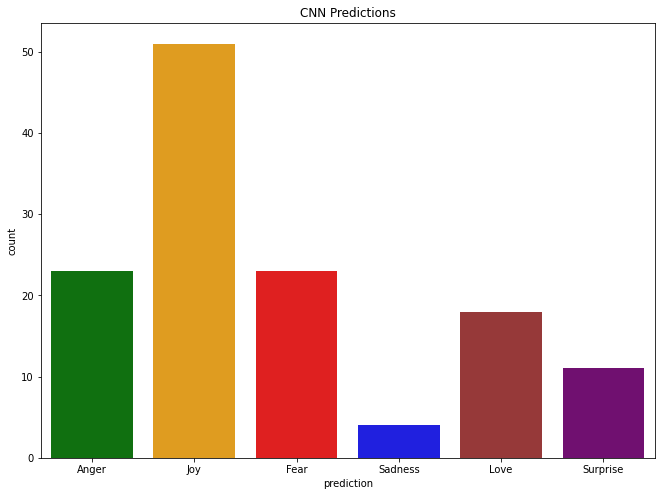

In [98]:
# CNN Output

df_sub = df.loc[df['Site'] == 'Cnn']

cnn_results = df_sub['prediction']

plt.figure(figsize=(11,8))
plt.title("CNN Predictions")
sns.countplot(x=cnn_results, palette = {'Fear':'red','Anger':'green',"Sadness": "blue","Joy":'orange',"Love":"brown","Surprise":'purple'})
plt.show()

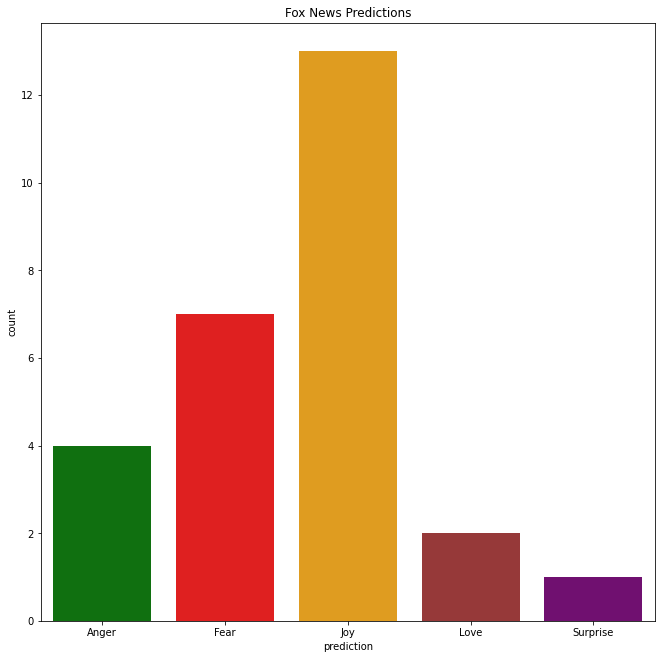

In [94]:
# Fox News Output
df_sub = df.loc[df['Site'] == 'Fox'] 
fn_results = df_sub['prediction']

plt.figure(figsize=(11,8)))
plt.title("Fox News Predictions")
sns.countplot(x=fn_results, palette = {'Fear':'red','Anger':'green',"Sadness": "blue","Joy":'orange',"Love":"brown","Surprise":'purple'})
plt.show()

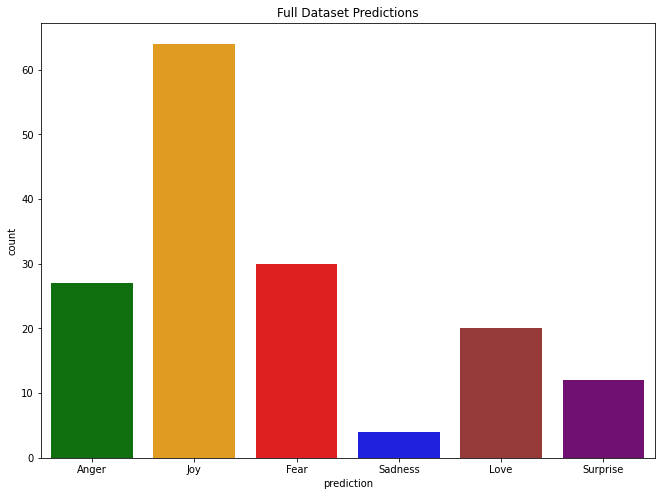

In [99]:
# Full Dataset Output

full_results = df.prediction

plt.figure(figsize=(11,8))
plt.title("Full Dataset Predictions")
sns.countplot(x=full_results, palette = {'Fear':'red','Anger':'green',"Sadness": "blue","Joy":'orange',"Love":"brown","Surprise":'purple'})

plt.show()

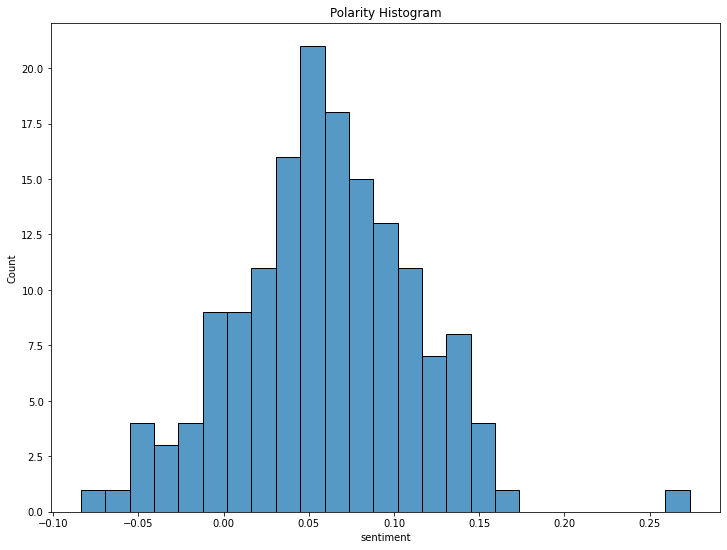

In [100]:
plt.figure(figsize=(12,9))
plt.title("Polarity Histogram")
sns.histplot(df.sentiment, bins = 25)
plt.show()

## Emotion Index

 I also wanted to test the level of fear predicted even when it wasn't the highest-predicted emotion. For this I created the emotion index, which shows the distribution of the Softmax probabilities associated with fear or another associated emotion for every single prediction to see their relative strength.

In [79]:
def fear_prediction(location, model):
  """
  Returns the softmax probability of the 'fear' label.
  """
  preds = F.softmax(model(location.reshape(1,-1)), dim = -1)
  preds_list = preds.tolist()

  for index in range(len(emo_dataset_15.label_names)):
    if emo_dataset_15.label_names[index] == "fear":
      fear_idx = preds[0,index].item()
    else:
      continue

  return fear_idx


def anger_prediction(location, model):
    preds = F.softmax(model(location.reshape(1,-1)), dim = -1)
    preds_list = preds.tolist()

    for index in range(len(emo_dataset_15.label_names)):
      if emo_dataset_15.label_names[index] == "anger":
        anger_idx = preds[0,index].item()
      else:
        continue

    return anger_idx


def sadness_prediction(location, model):
    preds = F.softmax(model(location.reshape(1,-1)), dim = -1)
    preds_list = preds.tolist()

    for index in range(len(emo_dataset_15.label_names)):
      if emo_dataset_15.label_names[index] == "sadness":
        sadness_idx = preds[0,index].item()
      else:
        continue

    return sadness_idx


def joy_prediction(location, model):
    preds = F.softmax(model(location.reshape(1,-1)), dim = -1)
    preds_list = preds.tolist()

    for index in range(len(emo_dataset_15.label_names)):
      if emo_dataset_15.label_names[index] == "joy":
        joy_idx = preds[0,index].item()
      else:
        continue

    return joy_idx


def love_prediction(location, model):
    preds = F.softmax(model(location.reshape(1,-1)), dim = -1)
    preds_list = preds.tolist()

    for index in range(len(emo_dataset_15.label_names)):
      if emo_dataset_15.label_names[index] == "love":
        love_idx = preds[0,index].item()
      else:
        continue

    return love_idx


def surprise_prediction(location, model):
    preds = F.softmax(model(location.reshape(1,-1)), dim = -1)
    preds_list = preds.tolist()

    for index in range(len(emo_dataset_15.label_names)):
      if emo_dataset_15.label_names[index] == "surprise":
        surprise_idx = preds[0,index].item()
      else:
        continue

    return surprise_idx

In [80]:
df['fear_prediction'] = df.tensor.apply(lambda x: fear_prediction(x, model_best))
df['anger_prediction'] = df.tensor.apply(lambda x: anger_prediction(x, model_best))
df['sadness_prediction'] = df.tensor.apply(lambda x: sadness_prediction(x, model_best))
df['joy_prediction'] = df.tensor.apply(lambda x: joy_prediction(x, model_best))
df['love_prediction'] = df.tensor.apply(lambda x: love_prediction(x, model_best))
df['surprise_prediction'] = df.tensor.apply(lambda x: surprise_prediction(x, model_best))

In [81]:
df.head()

,Title,lemma_string,Site,cleaned,vector,vector_length,tensor,prediction,sentiment,fear_prediction,anger_prediction,sadness_prediction,joy_prediction,love_prediction,surprise_prediction
0,Opinion: It won't be long before extremists in...,julian zelizer cnn political analyst professor...,Cnn,julian zelizer cnn political analyst professor...,"[julian, zelizer, cnn, political, analyst, pro...",760,"[tensor(4), tensor(5), tensor(6), tensor(7), t...",Anger,0.095127,0.252767,0.128746,0.149435,0.226455,0.211768,0.030828
1,Michael Osterholm: Covid-19 keeps firing 210-m...,peter bergen cnn 's national security analyst ...,Cnn,peter bergen cnn s national security analyst v...,"[peter, bergen, cnn, s, national, security, an...",1317,"[tensor(517), tensor(5), tensor(97), tensor(51...",Joy,0.077829,0.114747,0.141839,0.140753,0.180121,0.320331,0.102208
2,Opinion: Katie Porter's example reveals a pivo...,( cnn ) private meeting house democratic caucu...,Cnn,cnn private meeting house democratic caucus l...,"[, cnn, private, meeting, house, democratic, c...",449,"[tensor(5), tensor(967), tensor(968), tensor(2...",Fear,0.060120,0.232897,0.350843,0.168595,0.102725,0.135734,0.009206
3,Opinion: Why the baby formula shortage is so t...,syra madad dhsc msc mcp infectious disease epi...,Cnn,syra madad dhsc msc mcp infectious disease epi...,"[syra, madad, dhsc, msc, mcp, infectious, dise...",578,"[tensor(1124), tensor(1125), tensor(1126), ten...",Fear,0.108765,0.217251,0.338996,0.255648,0.066880,0.076412,0.044814
4,Opinion: Trust in the Supreme Court is grievou...,barbara a. perry gerald l. baliles professor d...,Cnn,barbara a perry gerald l baliles professor dir...,"[barbara, a, perry, gerald, l, baliles, profes...",788,"[tensor(1314), tensor(1315), tensor(1316), ten...",Sadness,0.050644,0.122494,0.117908,0.209317,0.227397,0.176010,0.146875


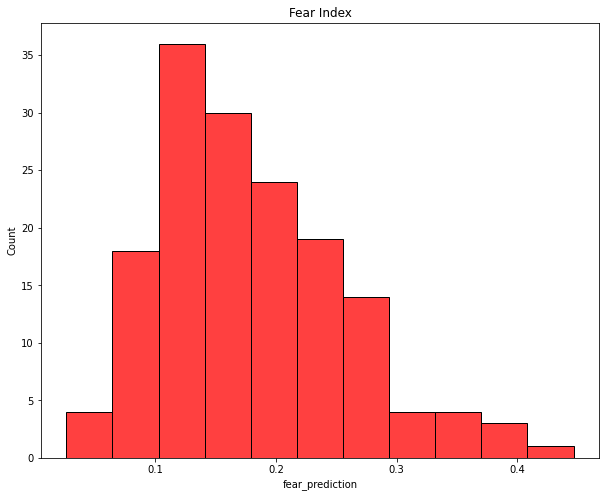

In [84]:
plt.figure(figsize = (10,8))
plt.title("Fear Index")
sns.histplot(data=df, x=df.fear_prediction, color="red", label="Fear Prediction", kde=False)
plt.show()

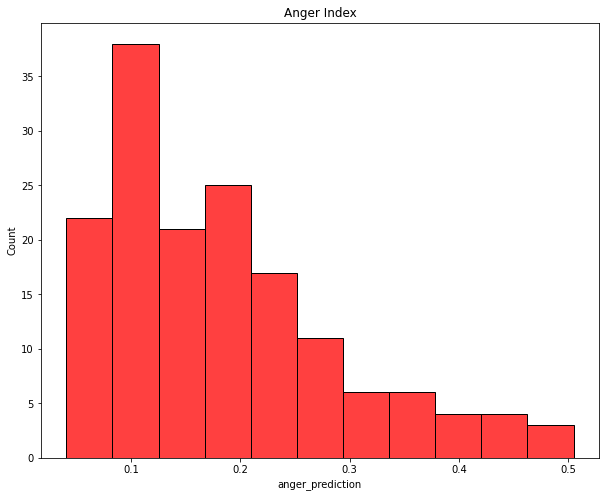

In [85]:
plt.figure(figsize = (10,8))
plt.title("Anger Index")
sns.histplot(data=df, x=df.anger_prediction, color="red", label="Anger Prediction", kde=False)
plt.show()

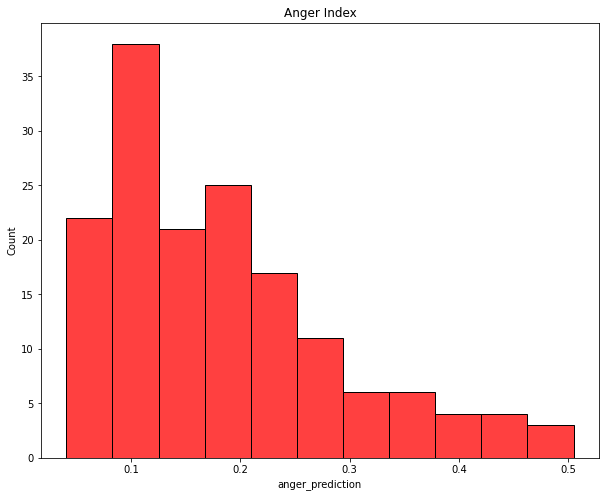

In [87]:
plt.figure(figsize = (10,8))
plt.title("Anger Index")
sns.histplot(data=df, x=df.anger_prediction, color="red")
plt.show()

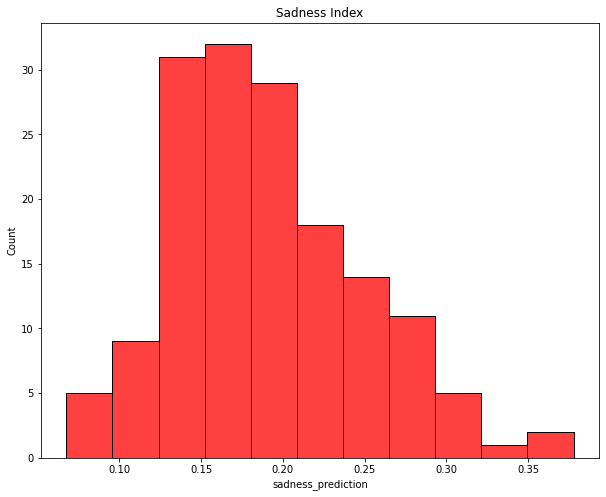

In [88]:
plt.figure(figsize = (10,8))
plt.title("Sadness Index")
sns.histplot(data=df, x=df.sadness_prediction, color="red")
plt.show()

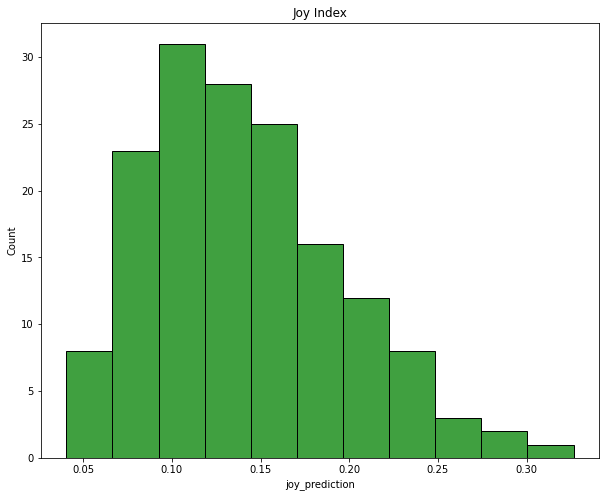

In [89]:
plt.figure(figsize = (10,8))
plt.title("Joy Index")
sns.histplot(data=df, x=df.joy_prediction, color="green")
plt.show()

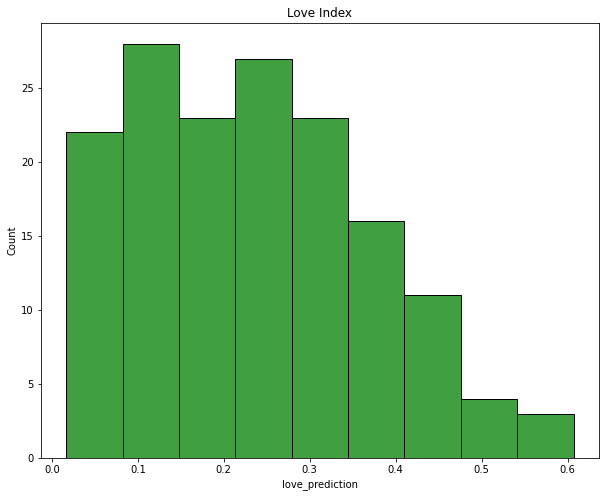

In [91]:
plt.figure(figsize = (10,8))
plt.title("Love Index")
sns.histplot(data=df, x=df.love_prediction, color="green")
plt.show()

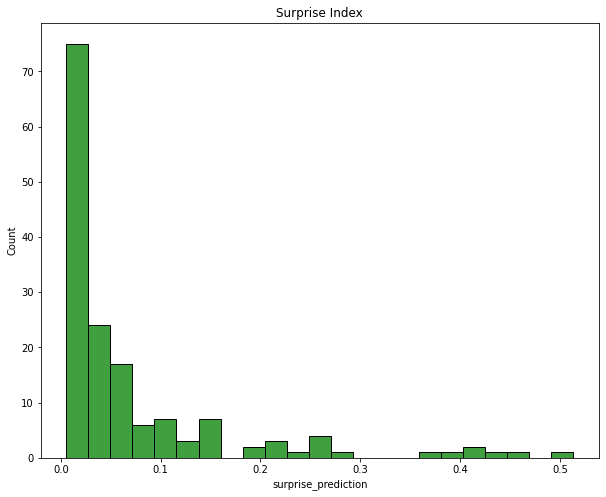

In [92]:
plt.figure(figsize = (10,8))
plt.title("Surprise Index")
sns.histplot(data=df, x=df.surprise_prediction, color="green")
plt.show()